In [1]:
# Import libraries and dependencies
!pip install yfinance
!pip install hvplot
!pip install python-dotenv 
!pip install -q holoviews
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import yfinance as yf

from fbprophet import Prophet
import json
from fbprophet.serialize import model_to_json, model_from_json

import numpy as np
import hvplot.pandas
import holoviews as hv
from holoviews import opts

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
hv.extension('bokeh')

Output hidden; open in https://colab.research.google.com to view.

In [2]:
def fetch_yahoo(ticker, years):
    
    range = 365*years
    today = pd.Timestamp.today(tz="America/New_York")

    start = today + pd.Timedelta(days=-1-range)
    start= start.strftime('%Y-%m-%d')
    print(f'Start date = {start}')

    end = today + pd.Timedelta(days=-2)
    end = end.strftime('%Y-%m-%d')
    print(f'End date = {end}')   

    # Get Data
    yfObj = yf.Ticker(ticker)
    stock_df = yfObj.history(start=start, end=end)
    # Drop unused columns
    stock_df.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], inplace=True, axis=1)
    stock_df.reset_index(inplace=True)
    stock_df.rename(columns={'Date':'ds', 'Close':'y'}, inplace=True)
    return stock_df

In [3]:
# Create hlc DataFrame for Microsoft
ticker='MSFT'

# Get current closing prices for MSFT
msft_df = fetch_yahoo(ticker, 2)

# Display sample data
display(msft_df.head())
display(msft_df.tail())
print(msft_df.shape)


# Plot the DataFrame with hvplot
msft_df['y'].hvplot()

Start date = 2020-06-03
End date = 2022-06-02


,ds,y
0,2020-06-03,182.095535
1,2020-06-04,179.698502
2,2020-06-05,183.903122
3,2020-06-08,185.042694
4,2020-06-09,186.457352


,ds,y
499,2022-05-25,262.519989
500,2022-05-26,265.899994
501,2022-05-27,273.239990
502,2022-05-31,271.869995
503,2022-06-01,272.420013


(504, 2)


:Curve   [index]   (y)

In [4]:
# Call the Prophet function, store as an object
model_msft = Prophet()
model_msft

In [5]:
# Fit the model
model_msft.fit(msft_df)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [6]:
# Forecast two week of future trends data for Canada 
future_msft = model_msft.make_future_dataframe(periods=14, freq="D")

# Display the last five rows of the DataFrame
future_msft.tail()

,ds
513,2022-06-11
514,2022-06-12
515,2022-06-13
516,2022-06-14
517,2022-06-15


In [7]:
# Make predictions for MSFT 
forecast_msft = model_msft.predict(future_msft)

# Display the first five rows of the forecast_canada DataFrame
forecast_msft.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-03,191.250803,182.490995,205.181145,191.250803,191.250803,2.311512,2.311512,2.311512,2.311512,2.311512,2.311512,0.0,0.0,0.0,193.562316
1,2020-06-04,191.411305,181.568223,202.820636,191.411305,191.411305,1.700933,1.700933,1.700933,1.700933,1.700933,1.700933,0.0,0.0,0.0,193.112238
2,2020-06-05,191.571807,181.148826,204.103071,191.571807,191.571807,1.773648,1.773648,1.773648,1.773648,1.773648,1.773648,0.0,0.0,0.0,193.345454
3,2020-06-08,192.053312,183.861360,205.394655,192.053312,192.053312,2.004606,2.004606,2.004606,2.004606,2.004606,2.004606,0.0,0.0,0.0,194.057918
4,2020-06-09,192.213814,183.498139,205.401213,192.213814,192.213814,1.784357,1.784357,1.784357,1.784357,1.784357,1.784357,0.0,0.0,0.0,193.998171


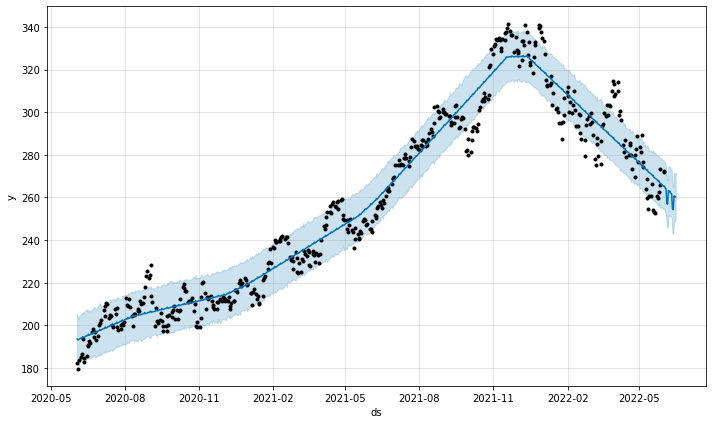

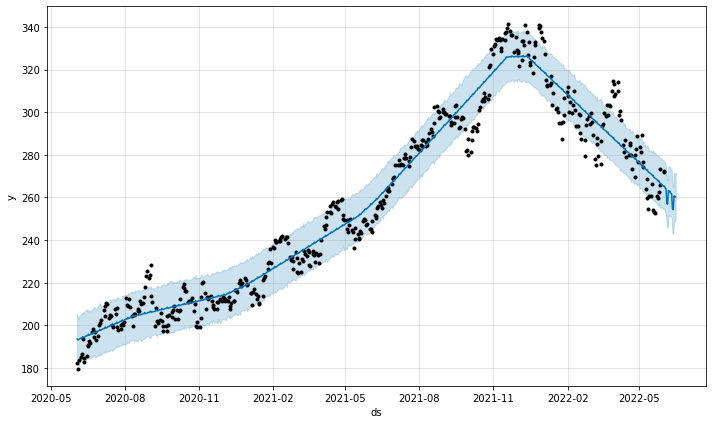

In [8]:
# Plot the forecast
model_msft.plot(forecast_msft)

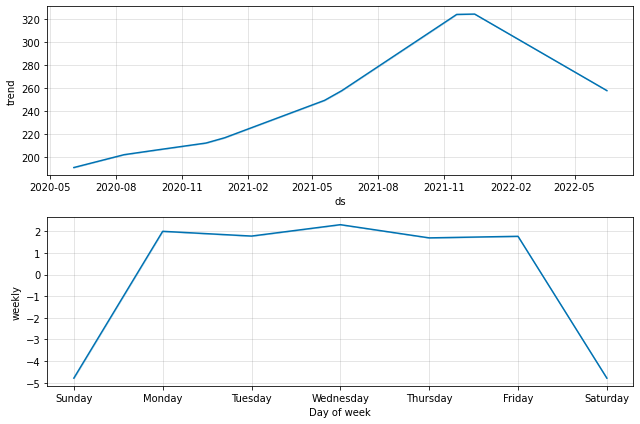

In [9]:
# Plot the different patterns
fig_msft = model_msft.plot_components(forecast_msft)

In [10]:
# Analyze the forecast results specifially for the two week period
forecast_msft = forecast_msft.set_index('ds')
forecast_msft.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2020-06-03,191.250803,182.490995,205.181145,191.250803,191.250803,2.311512,2.311512,2.311512,2.311512,2.311512,2.311512,0.0,0.0,0.0,193.562316
2020-06-04,191.411305,181.568223,202.820636,191.411305,191.411305,1.700933,1.700933,1.700933,1.700933,1.700933,1.700933,0.0,0.0,0.0,193.112238
2020-06-05,191.571807,181.148826,204.103071,191.571807,191.571807,1.773648,1.773648,1.773648,1.773648,1.773648,1.773648,0.0,0.0,0.0,193.345454
2020-06-08,192.053312,183.861360,205.394655,192.053312,192.053312,2.004606,2.004606,2.004606,2.004606,2.004606,2.004606,0.0,0.0,0.0,194.057918
2020-06-09,192.213814,183.498139,205.401213,192.213814,192.213814,1.784357,1.784357,1.784357,1.784357,1.784357,1.784357,0.0,0.0,0.0,193.998171


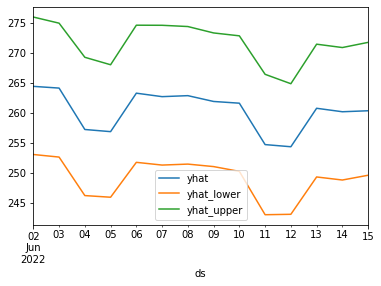

In [11]:
# Plot the results
forecast_plot = forecast_msft[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-14:,:].plot()
forecast_plot

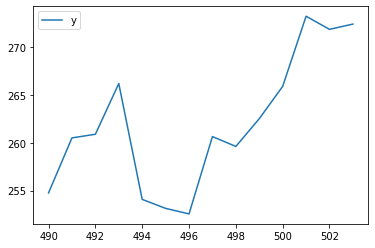

In [12]:
actual_plot = msft_df[["y"]].iloc[-14:,:].plot()
actual_plot
# * get hvplots to work on colab to combine these graphs

# comparative_plot = forecast_plot * actual_plot
# comparative_plot

In [13]:
two_week_forecast = forecast_msft.iloc[-14:,:][['yhat_upper', 'yhat_lower', 'yhat']]

two_week_forecast = two_week_forecast.rename(
    columns={
        'yhat_upper': 'Best Case',
        'yhat_lower':'Worst Case', 
        'yhat':'Most Likely Case'
    }
)
two_week_forecast.head()

,Best Case,Worst Case,Most Likely Case
ds,,,
2022-06-02,276.013585,253.035950,264.425556
2022-06-03,274.988495,252.604439,264.137610
2022-06-04,269.286077,246.167685,257.215774
2022-06-05,268.038479,245.892138,256.855113
2022-06-06,274.650083,251.725559,263.286586


In [14]:
two_week_forecast.mean()

Best Case           271.696153
Worst Case          249.069564
Most Likely Case    260.380329
dtype: float64

In [18]:
# Make ml testing/training sets for original stock data (MSFT here)
def fetch_yahoo(ticker, years):
    
    range = 365*years
    today = pd.Timestamp.today(tz="America/New_York")

    start = today + pd.Timedelta(days=-1-range)
    start= start.strftime('%Y-%m-%d')
    print(f'Start date = {start}')

    end = today + pd.Timedelta(days=-2)
    end = end.strftime('%Y-%m-%d')
    print(f'End date = {end}')   

    # Get Data
    yfObj = yf.Ticker(ticker)
    stock_df = yfObj.history(start=start, end=end)
    # Drop unused columns
    stock_df.drop(['Dividends', 'Stock Splits'], inplace=True, axis=1)
    return stock_df

In [19]:
# Create hlc DataFrame for Microsoft
ticker='MSFT'

# Get current closing prices for MSFT
msft_ml_df = fetch_yahoo(ticker, 2)

# Display sample data
display(msft_ml_df.head())
display(msft_ml_df.tail())
print(msft_ml_df.shape)

Start date = 2020-06-03
End date = 2022-06-02


,Open,High,Low,Close,Volume
Date,,,,,
2020-06-03,181.565067,182.665338,180.346900,182.095551,27311000
2020-06-04,181.054218,182.567090,179.089441,179.698517,28761800
2020-06-05,179.403811,184.423817,178.804553,183.903152,39893600
2020-06-08,182.665346,185.229381,181.191763,185.042725,33211600
2020-06-09,184.689049,187.341495,183.962076,186.457352,29783900


,Open,High,Low,Close,Volume
Date,,,,,
2022-05-25,258.140015,264.579987,257.130005,262.519989,28547900
2022-05-26,262.269989,267.109985,261.429993,265.899994,25002100
2022-05-27,268.480011,273.339996,267.559998,273.239990,26910800
2022-05-31,272.529999,274.769989,268.929993,271.869995,37827700
2022-06-01,275.200012,277.690002,270.040009,272.420013,25292200


(504, 5)


In [21]:
# Filter the date index and close columns
msft_signals_df = msft_ml_df.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
msft_signals_df["Actual Returns"] = msft_signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
msft_signals_df = msft_signals_df.dropna()

# Review the DataFrame
display(msft_signals_df.head())
display(msft_signals_df.tail())

,Close,Actual Returns
Date,,
2020-06-04,179.698517,-0.013164
2020-06-05,183.903152,0.023398
2020-06-08,185.042725,0.006197
2020-06-09,186.457352,0.007645
2020-06-10,193.373352,0.037092


,Close,Actual Returns
Date,,
2022-05-25,262.519989,0.011170
2022-05-26,265.899994,0.012875
2022-05-27,273.239990,0.027604
2022-05-31,271.869995,-0.005014
2022-06-01,272.420013,0.002023


In [23]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
msft_signals_df['SMA_Fast'] = msft_signals_df['Close'].rolling(window=short_window).mean()
msft_signals_df['SMA_Slow'] = msft_signals_df['Close'].rolling(window=long_window).mean()

msft_signals_df = msft_signals_df.dropna()

# Review the DataFrame
display(msft_signals_df.head())
display(msft_signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2020-10-23,212.935364,0.006236,211.864429,204.366340
2020-10-26,206.879074,-0.028442,210.739342,204.638146
2020-10-27,210.000778,0.015090,210.357750,204.899122
2020-10-28,199.591827,-0.049566,207.351761,205.044613
2020-10-29,201.600739,0.010065,204.518105,205.196047


,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2022-05-25,262.519989,0.011170,258.837494,291.355518
2022-05-26,265.899994,0.012875,262.172493,290.681688
2022-05-27,273.239990,0.027604,265.319992,290.138406
2022-05-31,271.869995,-0.005014,268.382492,289.707170
2022-06-01,272.420013,0.002023,270.857498,289.306326


In [25]:
# Initialize the new Signal column
msft_signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
msft_signals_df.loc[(msft_signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
msft_signals_df.loc[(msft_signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(msft_signals_df.head())
display(msft_signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2020-10-23,212.935364,0.006236,211.864429,204.366340,1.0
2020-10-26,206.879074,-0.028442,210.739342,204.638146,-1.0
2020-10-27,210.000778,0.015090,210.357750,204.899122,1.0
2020-10-28,199.591827,-0.049566,207.351761,205.044613,-1.0
2020-10-29,201.600739,0.010065,204.518105,205.196047,1.0


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2022-05-25,262.519989,0.011170,258.837494,291.355518,1.0
2022-05-26,265.899994,0.012875,262.172493,290.681688,1.0
2022-05-27,273.239990,0.027604,265.319992,290.138406,1.0
2022-05-31,271.869995,-0.005014,268.382492,289.707170,-1.0
2022-06-01,272.420013,0.002023,270.857498,289.306326,1.0


In [27]:
msft_signals_df['Signal'].value_counts()

 1.0    210
-1.0    194
Name: Signal, dtype: int64

In [28]:
# Calculate the strategy returns and add them to the msft_signals_df DataFrame
msft_signals_df['Strategy Returns'] = msft_signals_df['Actual Returns'] * msft_signals_df['Signal'].shift()

# Review the DataFrame
display(msft_signals_df.head())
display(msft_signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2020-10-23,212.935364,0.006236,211.864429,204.366340,1.0,NaN
2020-10-26,206.879074,-0.028442,210.739342,204.638146,-1.0,-0.028442
2020-10-27,210.000778,0.015090,210.357750,204.899122,1.0,-0.015090
2020-10-28,199.591827,-0.049566,207.351761,205.044613,-1.0,-0.049566
2020-10-29,201.600739,0.010065,204.518105,205.196047,1.0,-0.010065


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2022-05-25,262.519989,0.011170,258.837494,291.355518,1.0,-0.011170
2022-05-26,265.899994,0.012875,262.172493,290.681688,1.0,0.012875
2022-05-27,273.239990,0.027604,265.319992,290.138406,1.0,0.027604
2022-05-31,271.869995,-0.005014,268.382492,289.707170,-1.0,-0.005014
2022-06-01,272.420013,0.002023,270.857498,289.306326,1.0,-0.002023


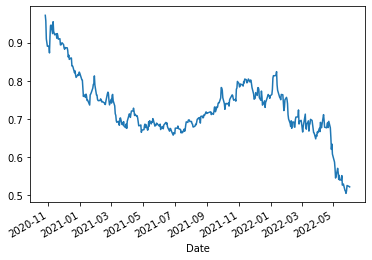

In [32]:
# Plot Strategy Returns to examine performance
(1 + msft_signals_df['Strategy Returns']).cumprod().plot()

In [34]:
# Split data into training/testing sets
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = msft_signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
Date,,
2020-10-26,211.864429,204.366340
2020-10-27,210.739342,204.638146
2020-10-28,210.357750,204.899122
2020-10-29,207.351761,205.044613
2020-10-30,204.518105,205.196047


In [35]:
# Create the target set selecting the Signal column and assiging it to y
y = msft_signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    210
-1.0    194
Name: Signal, dtype: int64

In [36]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2020-10-26 00:00:00


In [49]:
# Select the ending period for the training data with an max offset of 19 months (closest to current date)
# Another easily toggleable section
training_end = X.index.min() + DateOffset(months=19)

# Display the training end date
print(training_end)

2022-05-26 00:00:00


In [50]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
Date,,
2020-10-26,211.864429,204.366340
2020-10-27,210.739342,204.638146
2020-10-28,210.357750,204.899122
2020-10-29,207.351761,205.044613
2020-10-30,204.518105,205.196047


In [51]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
Date,,
2020-10-26,211.864429,204.366340
2020-10-27,210.739342,204.638146
2020-10-28,210.357750,204.899122
2020-10-29,207.351761,205.044613
2020-10-30,204.518105,205.196047


In [52]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [53]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_train_scaled)

# Review the model's predicted values
svm_pred[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [54]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_train, svm_pred)


# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.55      0.28      0.37       193
         1.0       0.54      0.79      0.64       207

    accuracy                           0.54       400
   macro avg       0.55      0.53      0.51       400
weighted avg       0.55      0.54      0.51       400



In [55]:
# Create svm model using testing data
msft_testing_predictions = svm_model.predict(X_test_scaled)

# Create a predictions DataFrame
msft_predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
msft_predictions_df['Predicted'] = msft_testing_predictions

# Add the actual returns to the DataFrame
msft_predictions_df['Actual Returns'] = msft_signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
msft_predictions_df['Strategy Returns'] = msft_signals_df['Strategy Returns']

# Review the DataFrame
display(msft_predictions_df.head())
display(msft_predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2022-05-27,1.0,0.027604,0.027604
2022-05-31,1.0,-0.005014,-0.005014
2022-06-01,1.0,0.002023,-0.002023


,Predicted,Actual Returns,Strategy Returns
Date,,,
2022-05-27,1.0,0.027604,0.027604
2022-05-31,1.0,-0.005014,-0.005014
2022-06-01,1.0,0.002023,-0.002023


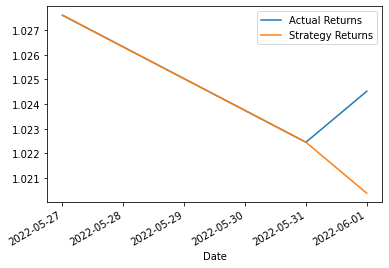

In [57]:
# Plot the actual returns versus the strategy returns
msft_trading_algo = (1 + msft_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
msft_trading_algo